# Прогнозирование температуры статора двигателя

Ста́тор — неподвижная часть электрической, лопаточной и другой машины, взаимодействующая с подвижной частью — ротором.

## О датасете

Описание полей:
* ambient - Температура окружающей среды, измеренная термодатчиком, расположенным близко к статору.
* coolant - Температура охлаждающей жидкости. Двигатель имеет водяное охлаждение. Измерение проводится на выходе.
* u_d - d-составляющая напряжения
* u_q - q-составляющая напряжения
* motor_speed - скорость двигателя
* torque - Крутящий момент, вызванный током.
* i_d - Текущая d-компонента
* i_q - Текущая q-компонента
* pm - Температура поверхности постоянного магнита, представляющая температуру ротора. Это было измерено с помощью инфракрасного термографа.
* stator_yoke - Температура ярма статора измеряется термодатчиком.
* stator_tooth - Температура зубца статора измеряется термодатчиком.
* stator_winding - Температура обмотки статора измеряется термодатчиком.
* profile_id - Каждый сеанс измерения имеет уникальный идентификатор.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bottleneck as bn

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense

In [31]:
dataset = pd.read_csv('pmsm_temperature_data.csv')
dataset.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


In [32]:
dataset.isnull().values.any()

False

In [33]:
dataset.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


<Figure size 640x480 with 0 Axes>

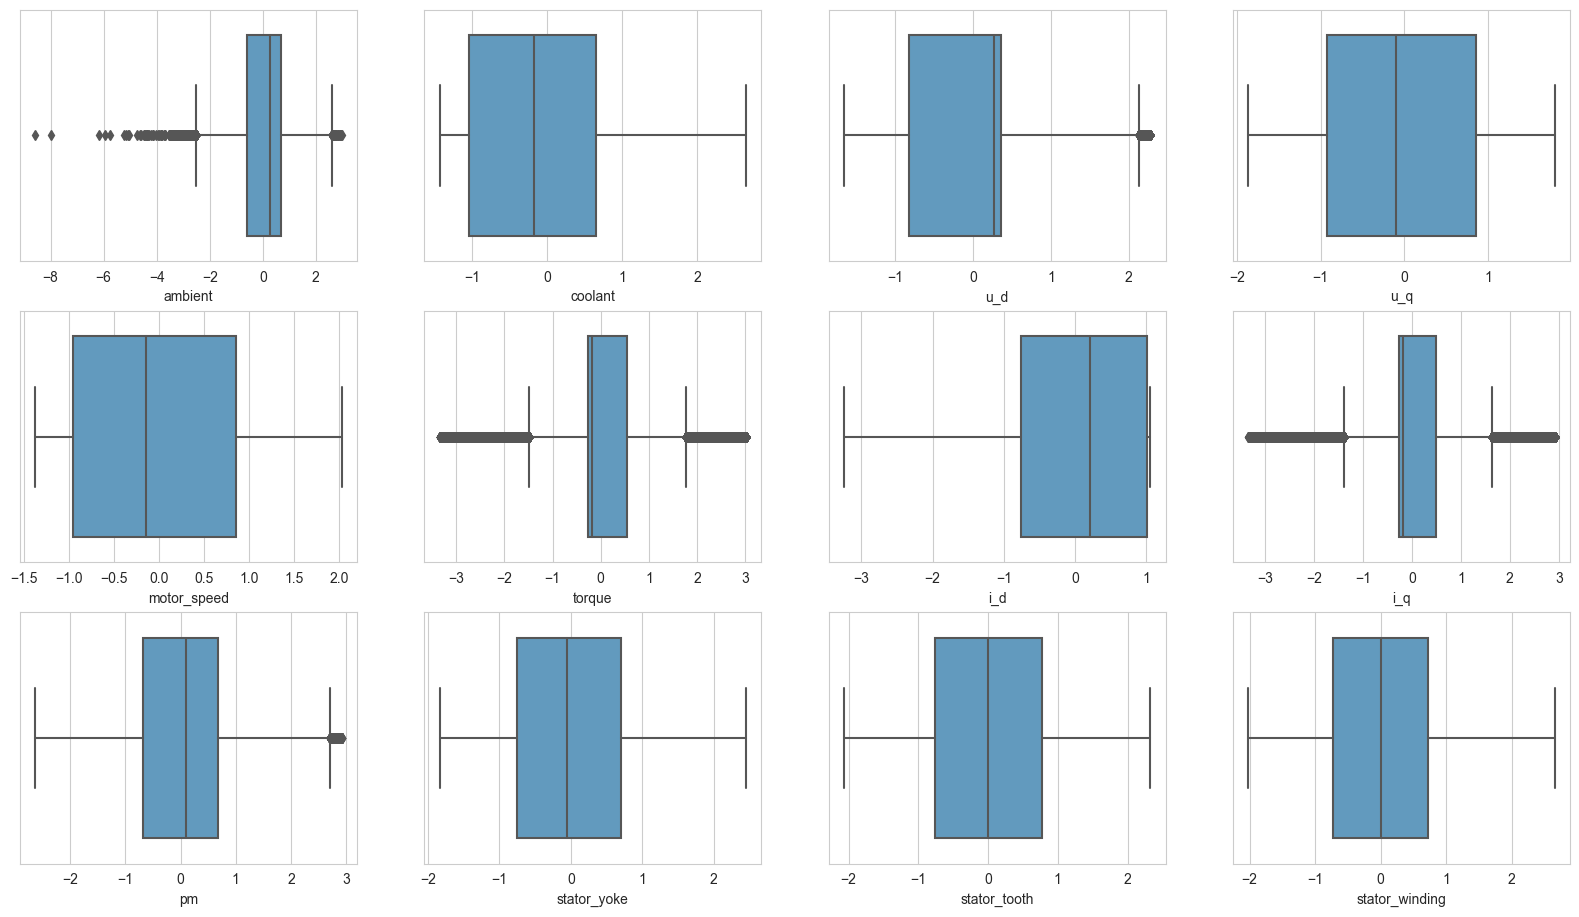

In [34]:
plt.tight_layout(pad=0.9)
plt.figure(figsize=(20,15))
plt.subplots_adjust(wspace = 0.2)
nbr_columns = 4
nbr_graphs = len(dataset.columns)
nbr_rows = int(np.ceil(nbr_graphs/nbr_columns))
columns = list(dataset.columns.values)
with sns.axes_style("whitegrid"):
    for i in range(0,len(columns)-1):
        plt.subplot(nbr_rows,nbr_columns,i+1)
        ax1=sns.boxplot(x= columns[i], data= dataset, orient="h",color=sns.color_palette("Blues")[3])
    plt.show()

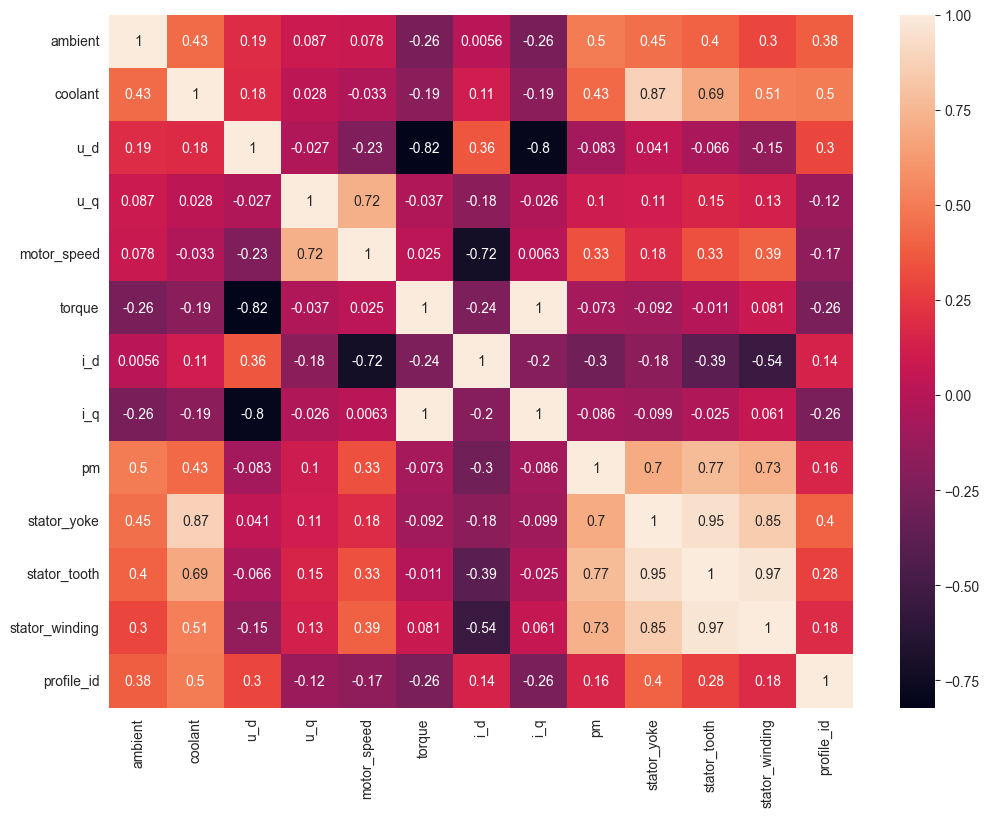

In [35]:
fig = plt.figure(figsize=(12,9))
sns.heatmap(dataset.corr(),annot=True)
plt.show()

In [36]:
profile_id_list = dataset.profile_id.unique()
print(profile_id_list)
print("amount of test runs: {0}".format(profile_id_list.size))

[ 4  6 10 11 20 27 29 30 31 32 36 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 73 74 75 76 77 78
 79 80 81 72]
amount of test runs: 52


In [37]:
X = dataset.drop('torque', axis=1).loc[:,'ambient':'i_q'].values
y = dataset.loc[:,'stator_winding'].values

# split up in training and test data
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2)

In [38]:
X.shape

(998070, 7)

In [39]:
nr_epochs=200
b_size=1000

NN_reg_model = Sequential()
NN_reg_model.add(Dense(11, input_dim=X_train.shape[1], activation='relu'))
NN_reg_model.add(Dense(9, activation='relu'))
NN_reg_model.add(Dense(7, activation='relu'))
NN_reg_model.add(Dense(5, activation='relu'))
NN_reg_model.add(Dense(1))
NN_reg_model.compile(loss='mean_squared_error', optimizer='adam',metrics = ["mean_squared_error"])
history = NN_reg_model.fit(X_train, y_train, validation_split=0.33,epochs=nr_epochs, batch_size=b_size, verbose=0)

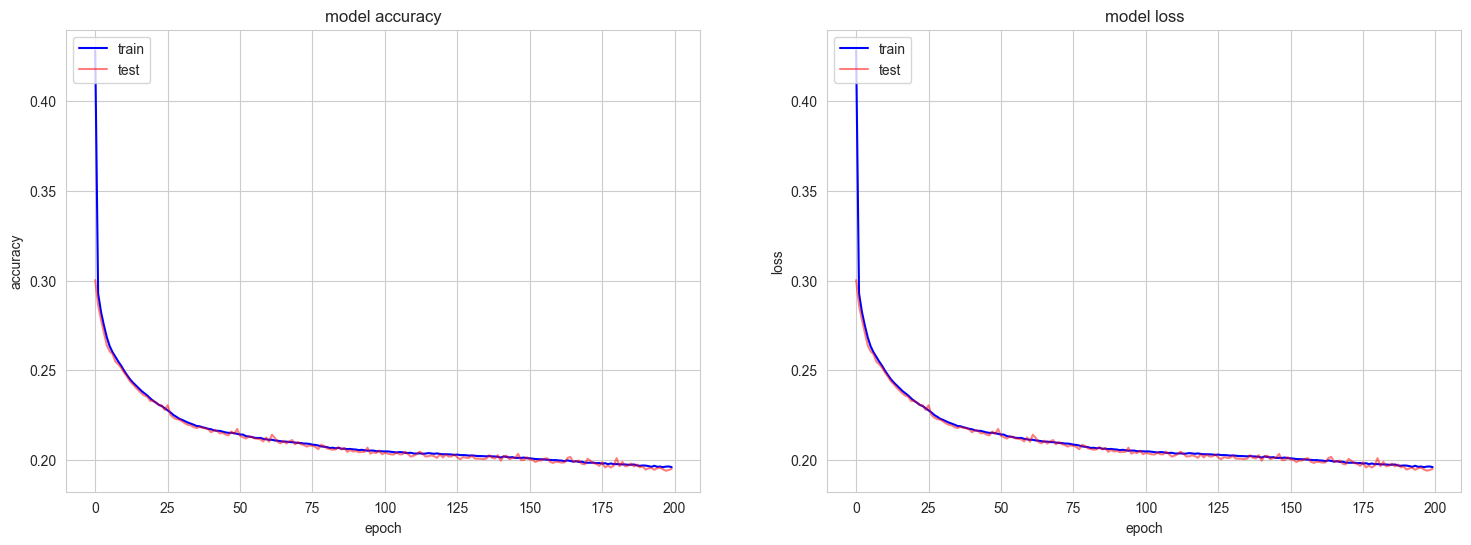

In [40]:
plt.figure(figsize=(18,6))
ax1=plt.subplot(1, 2, 1)
ax1=plt.plot(history.history['mean_squared_error'],color='blue')
ax1=plt.plot(history.history['val_mean_squared_error'],color='red',alpha=0.5)
ax1=plt.title('model accuracy')
ax1=plt.ylabel('accuracy')
ax1=plt.xlabel('epoch')
ax1=plt.legend(['train', 'test'], loc='upper left')

# plot the history of the model loss during training
ax2=plt.subplot(1, 2, 2)
ax2=plt.plot(history.history['loss'],color='blue')
ax2=plt.plot(history.history['val_loss'],color='red',alpha=0.5)
ax2=plt.title('model loss')
ax2=plt.ylabel('loss')
ax2=plt.xlabel('epoch')
ax2=plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
y_pred = NN_reg_model.predict(X_test)
NN_MSE = mean_squared_error(y_test, y_pred)
NN_MAE = mean_absolute_error(y_test, y_pred)
print("MSE: {0}".format(NN_MSE))
print("MAE: {0}".format(NN_MAE))

6238/6238 [==============================] - 5s 739us/step
MSE: 0.1954440355026956
MAE: 0.3142738269755479


743/743 [==============================] - 1s 744us/step


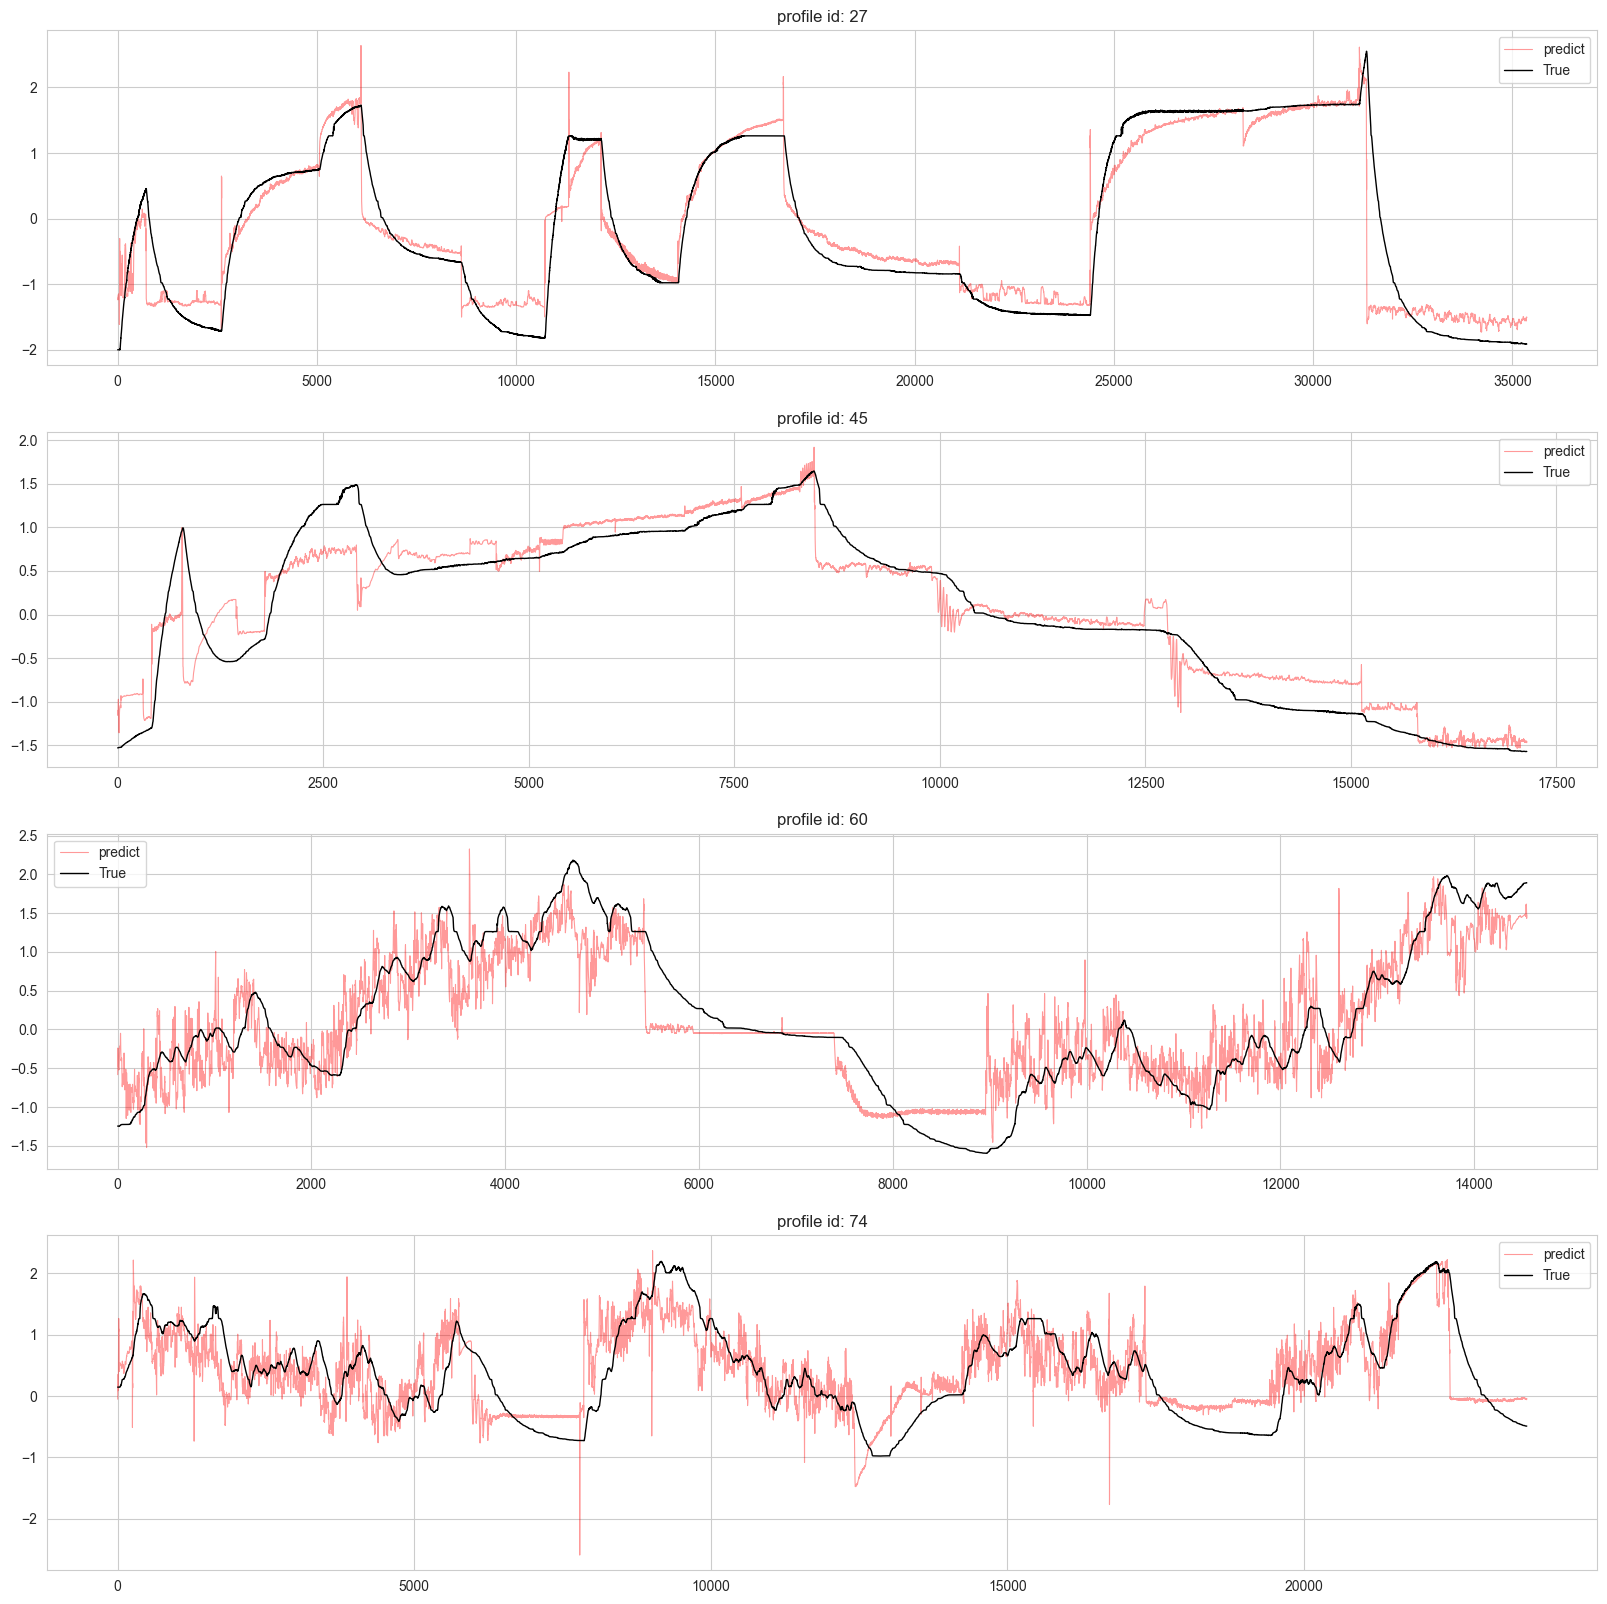

In [42]:
test_run_list = np.array([27,45,60,74])
output_value = 'stator_winding'
model = NN_reg_model

with sns.axes_style("whitegrid"):
    fig, axs = plt.subplots(len(test_run_list),1,figsize=(20,len(test_run_list)*5),squeeze=False)

    for i in range(0,len(test_run_list)):
        X_plot = dataset.drop('torque', axis=1).loc[dataset['profile_id'] == test_run_list[i],'ambient':'i_q'].values
        y_plot = dataset.loc[dataset['profile_id'] == test_run_list[i],output_value].values
        y_pred_plot = model.predict(X_plot)

        time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])
        axs[i,0].plot(time,y_pred_plot,label='predict',color='red',alpha=0.4,linewidth=0.8)
        axs[i,0].plot(time,y_plot,label='True',color='black',linewidth=1)
        axs[i,0].legend(loc='best')
        axs[i,0].set_title("profile id: {0}".format(test_run_list[i]))
    plt.show()

694/694 [==============================] - 1s 760us/step


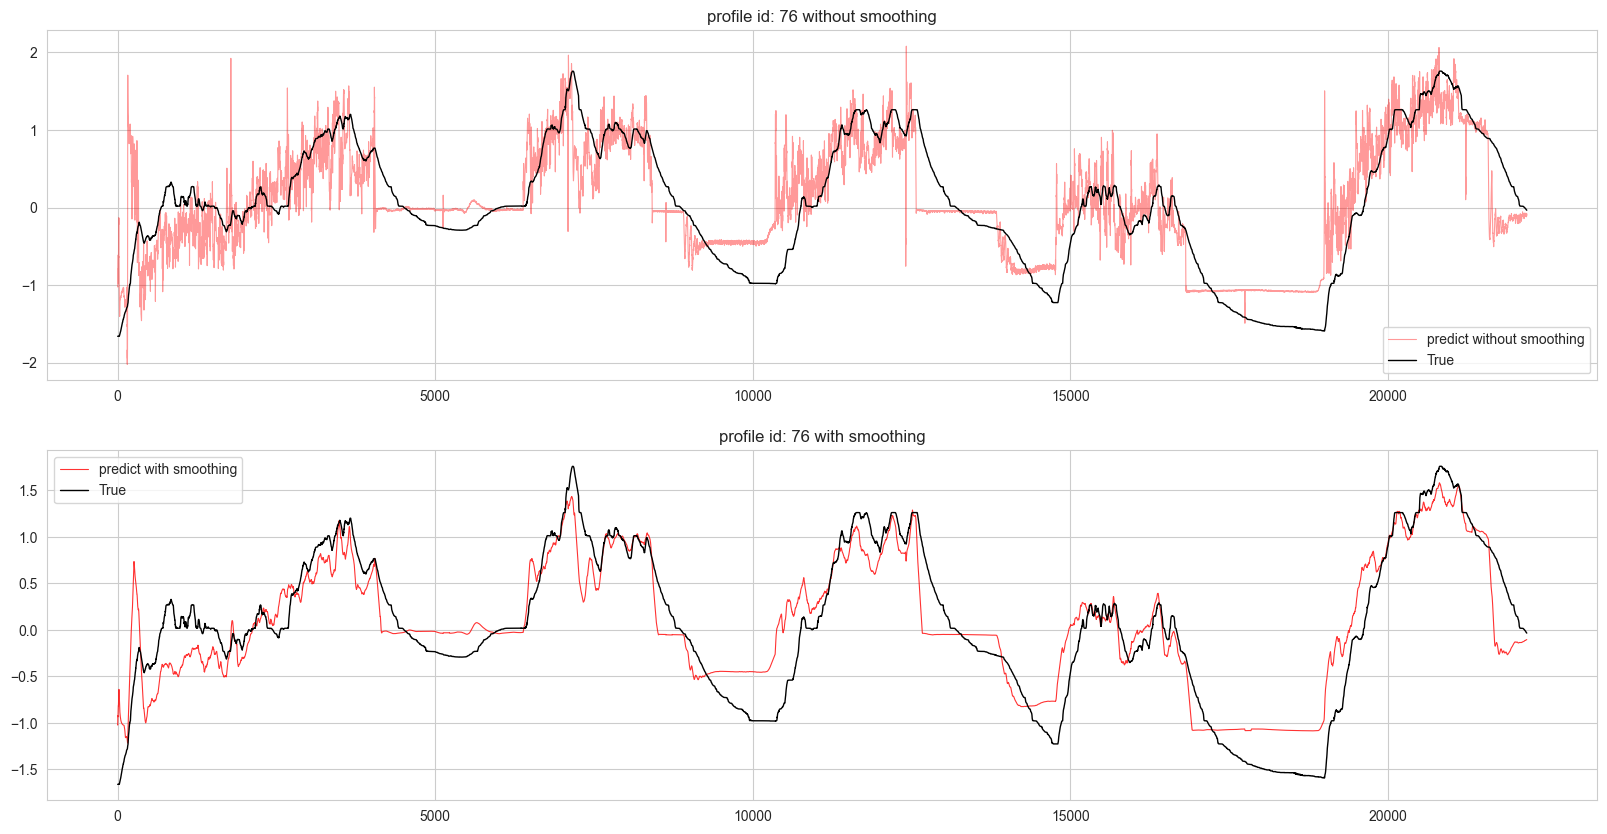

metrics without moving average smoothing:
MSE: 0.18979781421699637
MAE: 0.3292513476962546
metrics with moving average smoothing:
MSE: 0.115098751547321
MAE: 0.2641340017807204


In [43]:
choosen_example_testrun = 76
profile_id = choosen_example_testrun
output_value = 'stator_winding'
model = NN_reg_model
moving_average_window = 100

X_plot = dataset.drop('torque', axis=1).loc[dataset['profile_id'] == profile_id,'ambient':'i_q'].values
y_plot = dataset.loc[dataset['profile_id'] == profile_id,output_value].values
y_pred_plot = model.predict(X_plot).flatten()
y_pred_plot_smooth = bn.move_mean(y_pred_plot,moving_average_window,1)
time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(20, 10))

    ax1 = fig.add_subplot(211)
    ax1.plot(time,y_pred_plot,label='predict without smoothing',color='red',alpha=0.4,linewidth=0.8)
    ax1.plot(time,y_plot,label='True',color='black',linewidth=1)
    ax1.legend(loc='best')
    ax1.set_title("profile id: {0} without smoothing".format(profile_id))

    ax2 = fig.add_subplot(212)
    ax2.plot(time,y_pred_plot_smooth,label='predict with smoothing',color='red',alpha=0.8,linewidth=0.8)
    ax2.plot(time,y_plot,label='True',color='black',linewidth=1)
    ax2.legend(loc='best')
    ax2.set_title("profile id: {0} with smoothing".format(profile_id))

    plt.show()

MSE_RFR_model = mean_squared_error(y_plot, y_pred_plot)
MAE_RFR_model = mean_absolute_error(y_plot, y_pred_plot)
print("metrics without moving average smoothing:")
print("MSE: {0}".format(MSE_RFR_model))
print("MAE: {0}".format(MAE_RFR_model))
MSE_RFR_model = mean_squared_error(y_plot, y_pred_plot_smooth)
MAE_RFR_model = mean_absolute_error(y_plot, y_pred_plot_smooth)
print("metrics with moving average smoothing:")
print("MSE: {0}".format(MSE_RFR_model))
print("MAE: {0}".format(MAE_RFR_model))